# CNN 지도학습

체스 데이터로 CNN 모델을 지도학습합니다.

이 모델은 이후 강화학습의 정책 신경망으로 사용됩니다.

## 모델 구조
- **입력**: (18, 8, 8) 체스 보드 상태
- **Policy Head**: 4096개 액션에 대한 확률 분포
- **Value Head**: 포지션 평가값 (-1 ~ 1)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
from pathlib import Path
from tqdm import tqdm

from parquet_dataset import (
    ParquetChessDataset,
    get_parquet_file_info, 
    split_files_by_ratio
)
from train_utils import create_tensorboard_writer, train_epoch, validate

torch.manual_seed(42)
np.random.seed(42)

if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.use_deterministic_algorithms(False, warn_only=True)
    device = torch.device("cuda")
    print(f"✅ CUDA 사용 가능!")
    print(f"   GPU: {torch.cuda.get_device_name(0)}")
    print(f"   CUDA 버전: {torch.version.cuda}")
    print(f"   PyTorch 버전: {torch.__version__}")
    print(f"   GPU 메모리: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.2f} GB")
else:
    device = torch.device("cpu")
    print(f"⚠️  CUDA 사용 불가 - CPU 사용")
    print(f"   PyTorch 버전: {torch.__version__}")

print(f"\n사용 장치: {device}")

✅ CUDA 사용 가능!
   GPU: NVIDIA GeForce RTX 5060 Ti
   CUDA 버전: 13.1
   PyTorch 버전: 2.10.0a0+b4e4ee81d3.nv25.12
   GPU 메모리: 15.93 GB

사용 장치: cuda


## 모델 정의

In [ ]:
class ChessCNN(nn.Module):
    """
    체스 CNN 모델
    
    Policy Head와 Value Head를 가진 구조로,
    지도학습 후 강화학습의 정책 신경망으로 사용됩니다.
    """
    
    def __init__(self, num_channels=256):
        super().__init__()
        
        # 입력: (batch, 18, 8, 8)
        # 공통 CNN 백본
        self.conv_layers = nn.Sequential(
            # 첫 번째 블록
            nn.Conv2d(18, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            
            # 두 번째 블록
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            
            # 세 번째 블록
            nn.Conv2d(128, num_channels, 3, padding=1),
            nn.BatchNorm2d(num_channels),
            nn.ReLU(),
        )
        
        # Policy Head (4096개 액션)
        self.policy_head = nn.Sequential(
            nn.Conv2d(num_channels, 32, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 4096),
        )
        
        # Value Head (1개 출력)
        self.value_head = nn.Sequential(
            nn.Conv2d(num_channels, 32, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(32 * 8 * 8, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Tanh()
        )
    
    def forward(self, x, mask=None):
        """
        Args:
            x: (batch, 18, 8, 8) 입력 텐서
            mask: (batch, 4096) 합법 수 마스크 (선택사항)
        
        Returns:
            policy_logits: (batch, 4096) 정책 로짓
            value: (batch, 1) 가치 예측
        """
        # 공통 백본
        features = self.conv_layers(x)
        
        # Policy Head
        policy_logits = self.policy_head(features)
        
        # Mask 적용 (불법 수 제거)
        if mask is not None:
            illegal_mask = mask < 0.5
            policy_logits = policy_logits.masked_fill(illegal_mask, float('-inf'))
        
        # Value Head
        value = self.value_head(features)
        
        return policy_logits, value


model = ChessCNN(num_channels=256).to(device)

# model = torch.compile(model, mode='default')

print(f"모델 파라미터 수: {sum(p.numel() for p in model.parameters()):,}")
print(f"학습 가능 파라미터 수: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

sample_input = torch.randn(2, 18, 8, 8).to(device)
sample_mask = torch.ones(2, 4096).to(device)
policy_logits, value = model(sample_input, sample_mask)
print(f"\n입력 shape: {sample_input.shape}")
print(f"Policy logits shape: {policy_logits.shape}")
print(f"Value shape: {value.shape}")

모델 파라미터 수: 9,314,433
학습 가능 파라미터 수: 9,314,433

입력 shape: torch.Size([2, 18, 8, 8])
Policy logits shape: torch.Size([2, 4096])
Value shape: torch.Size([2, 1])


## 데이터셋 설정

In [4]:
# 데이터 디렉토리 설정
PARQUET_DIR = "data/parquet"
TRAIN_RATIO = 0.9

# 파일 정보 수집 및 분할
parquet_files, file_lengths = get_parquet_file_info(PARQUET_DIR, "chess_samples_*.parquet")
train_files, val_files, train_lengths, val_lengths, train_samples, val_samples = split_files_by_ratio(
    parquet_files, 
    file_lengths, 
    train_ratio=TRAIN_RATIO,
    shuffle=False
)

# =============================================================================
# 성능 최적화 설정
# =============================================================================
BASE_BATCH_SIZE = 100   # 기준 배치 크기 (학습률 스케일링용)
BATCH_SIZE = 4096       # RTX 5060 Ti 16GB: 4096 권장 (OOM 발생 시 2048로 줄이기)
CHUNK_SIZE = 32768      # Parquet 파일 읽기 청크 크기

# 데이터셋 생성
print("\n학습 데이터셋 생성 중...")
train_dataset = ParquetChessDataset(
    parquet_files=train_files,
    file_lengths=train_lengths,
    shuffle_files=True,
    seed=42,
    batch_size=BATCH_SIZE,
    chunk_size=CHUNK_SIZE
)
val_dataset = ParquetChessDataset(
    parquet_files=val_files,
    file_lengths=val_lengths,
    shuffle_files=False,
    seed=42,
    batch_size=BATCH_SIZE,
    chunk_size=CHUNK_SIZE
)

print("\n검증 데이터셋 생성 중...")

print(f"\n최종 데이터셋 크기:")
print(f"  학습 데이터: {train_dataset.estimated_length:,} (스트리밍)")
print(f"  검증 데이터: {val_dataset.estimated_length:,} (스트리밍)")

# 멀티 워커 설정 (GPU 대기 시간 최소화)
# - 호스트 RAM 47GB 여유 있으므로 워커 수 증가
# - OOM 발생 시 NUM_WORKERS=2로 줄이기
NUM_WORKERS = 5
PREFETCH_FACTOR = 8  # 워커당 미리 로드할 배치 수

if torch.cuda.is_available():
    print(f"CUDA 사용 중")
    print(f"  배치 크기: {BATCH_SIZE} (기존 {BASE_BATCH_SIZE}에서 {BATCH_SIZE/BASE_BATCH_SIZE:.1f}x 증가)")
    print(f"  워커 수: {NUM_WORKERS}, 프리패치: {PREFETCH_FACTOR}")

# 에폭당 예상 이터레이션 수 (tqdm 진행률 표시용)
TRAIN_STEPS_PER_EPOCH = train_dataset.estimated_length // BATCH_SIZE
VAL_STEPS_PER_EPOCH = val_dataset.estimated_length // BATCH_SIZE
print(f"\n에폭당 이터레이션:")
print(f"  학습: {TRAIN_STEPS_PER_EPOCH:,} steps")
print(f"  검증: {VAL_STEPS_PER_EPOCH:,} steps")

train_loader = DataLoader(
    train_dataset,
    batch_size=None,  # Dataset이 이미 배치를 반환하므로 None
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,  # 공유 GPU 메모리 사용 안 함 (테스트)
    persistent_workers=NUM_WORKERS > 0,
    prefetch_factor=PREFETCH_FACTOR if NUM_WORKERS > 0 else None,
)

val_loader = DataLoader(
    val_dataset,
    batch_size=None,  # Dataset이 이미 배치를 반환하므로 None
    shuffle=False,
    num_workers=NUM_WORKERS,
    pin_memory=False,
    persistent_workers=NUM_WORKERS > 0,
    prefetch_factor=PREFETCH_FACTOR if NUM_WORKERS > 0 else None,
)

print("\n첫 배치 로딩 중...")
for states, policies, masks, values in train_loader:
    print(f"\n배치 shape 확인:")
    print(f"  States: {states.shape}")
    print(f"  Policies: {policies.shape}")
    print(f"  Masks: {masks.shape}")
    print(f"  Values: {values.shape}")
    break

print("\n데이터 로딩 준비 완료!")

Parquet 파일 정보 수집 중... (449개 파일)


파일 스캔: 100%|██████████| 449/449 [00:01<00:00, 420.71it/s]

총 파일 수: 449, 총 샘플 수: 22,450,000

파일 단위 분할 완료:
  Train: 405개 파일, 20,250,000개 샘플 (90.2%)
  Val: 44개 파일, 2,200,000개 샘플 (9.8%)

학습 데이터셋 생성 중...
파일 길이 정보 사용 (스캔 생략, 405개 파일)
총 샘플 수: 20,250,000
모드: 파일 순서 셔플, 배치 크기: 4096, 청크 크기: 32768
파일 길이 정보 사용 (스캔 생략, 44개 파일)
총 샘플 수: 2,200,000
모드: 순차 읽기, 배치 크기: 4096, 청크 크기: 32768

검증 데이터셋 생성 중...

최종 데이터셋 크기:
  학습 데이터: 20,250,000 (스트리밍)
  검증 데이터: 2,200,000 (스트리밍)
CUDA 사용 중
  배치 크기: 4096 (기존 100에서 41.0x 증가)
  워커 수: 5, 프리패치: 8

에폭당 이터레이션:
  학습: 4,943 steps
  검증: 537 steps

첫 배치 로딩 중...



배치 shape 확인:
  States: torch.Size([4096, 18, 8, 8])
  Policies: torch.Size([4096])
  Masks: torch.Size([4096, 4096])
  Values: torch.Size([4096])

데이터 로딩 준비 완료!


## 학습 설정

In [ ]:
# =============================================================================
# 학습 하이퍼파라미터
# =============================================================================
BASE_LEARNING_RATE = 0.001  # 기준 배치(100)에서의 학습률

# 선형 스케일링: 배치가 N배 커지면 학습률도 N배
# (단, 너무 크면 발산할 수 있어서 상한 설정)
LR_SCALE = min(BATCH_SIZE / BASE_BATCH_SIZE, 8.0)  # 최대 8배
LEARNING_RATE = BASE_LEARNING_RATE * LR_SCALE

NUM_EPOCHS = 10
POLICY_WEIGHT = 1.0
VALUE_WEIGHT = 1.0

# =============================================================================
# AMP (Automatic Mixed Precision) 설정
# =============================================================================
# - GPU 연산을 float16으로 수행해 속도 향상 + 메모리 절약
# - GradScaler로 gradient underflow 방지
USE_AMP = torch.cuda.is_available()
scaler = torch.amp.GradScaler('cuda', enabled=USE_AMP)

policy_loss_fn = nn.CrossEntropyLoss()
value_loss_fn = nn.MSELoss()

optimizer = optim.Adam(
    model.parameters(), 
    lr=LEARNING_RATE,
    betas=(0.9, 0.999),
    eps=1e-8,
    weight_decay=0.0,
    amsgrad=False
)

# Learning Rate Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', factor=0.5, patience=2
)

# 모델 저장 경로
MODEL_DIR = Path("models")
MODEL_DIR.mkdir(exist_ok=True)
BEST_MODEL_PATH = MODEL_DIR / "best_chess_cnn.pth"
LAST_MODEL_PATH = MODEL_DIR / "last_chess_cnn.pth"

# TensorBoard Writer 생성 (타임스탬프 기반)
writer = create_tensorboard_writer("cnn")

print(f"학습 설정:")
print(f"  Base LR: {BASE_LEARNING_RATE} → Scaled LR: {LEARNING_RATE:.6f} ({LR_SCALE:.1f}x)")
print(f"  Epochs: {NUM_EPOCHS}")
print(f"  Batch Size: {BATCH_SIZE}")
print(f"  Policy Weight: {POLICY_WEIGHT}")
print(f"  Value Weight: {VALUE_WEIGHT}")
print(f"  AMP (Mixed Precision): {'활성화' if USE_AMP else '비활성화'}")
print(f"\nTensorBoard 로그 디렉토리: {writer.log_dir}")
print(f"TensorBoard 실행: tensorboard --logdir=models/tensorboard")
print(f"브라우저에서 http://localhost:6006 접속")

학습 설정:
  Base LR: 0.001 → Scaled LR: 0.008000 (8.0x)
  Epochs: 10
  Batch Size: 4096
  Policy Weight: 1.0
  Value Weight: 1.0
  AMP (Mixed Precision): 활성화

TensorBoard 로그 디렉토리: models/tensorboard
TensorBoard 실행: tensorboard --logdir=models/tensorboard
브라우저에서 http://localhost:6006 접속


## 학습 함수

In [ ]:
# train_epoch, validate 함수는 train_utils.py에서 import됨
# 사용법:
#   train_metrics = train_epoch(model, train_loader, optimizer, ...)
#   val_metrics = validate(model, val_loader, ...)
print("train_epoch, validate 함수가 train_utils.py에서 로드되었습니다.")

## 학습 실행

In [ ]:
# 학습 히스토리
train_history = {
    'policy_loss': [],
    'value_loss': [],
    'total_loss': []
}

val_history = {
    'policy_loss': [],
    'value_loss': [],
    'total_loss': [],
    'accuracy': []
}

best_val_loss = float('inf')

print("=" * 60)
print("학습 시작")
print("=" * 60)

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"\nEpoch {epoch}/{NUM_EPOCHS}")
    print("-" * 60)
    
    # 에폭 설정 (파일 순서 셔플에 사용)
    train_dataset.set_epoch(epoch)
    
    # 학습
    train_metrics = train_epoch(
        model, train_loader, optimizer, policy_loss_fn, value_loss_fn,
        POLICY_WEIGHT, VALUE_WEIGHT, device,
        scaler=scaler, use_amp=USE_AMP, total_steps=TRAIN_STEPS_PER_EPOCH
    )
    
    # 검증 전 메모리 정리 (학습 워커 종료)
    # train_loader의 워커들을 종료하여 메모리 확보
    # iterator를 None으로 설정하면 워커가 자동으로 종료됨
    try:
        if hasattr(train_loader, '_iterator') and train_loader._iterator is not None:
            train_loader._iterator._shutdown_workers()
            train_loader._iterator = None
    except:
        pass  # iterator가 없거나 이미 종료된 경우 무시
    import gc
    gc.collect()
    torch.cuda.empty_cache()
    
    # 검증
    val_metrics = validate(
        model, val_loader, policy_loss_fn, value_loss_fn,
        POLICY_WEIGHT, VALUE_WEIGHT, device,
        use_amp=USE_AMP, total_steps=VAL_STEPS_PER_EPOCH
    )
    
    # 히스토리 저장
    train_history['policy_loss'].append(train_metrics['policy_loss'])
    train_history['value_loss'].append(train_metrics['value_loss'])
    train_history['total_loss'].append(train_metrics['total_loss'])
    
    val_history['policy_loss'].append(val_metrics['policy_loss'])
    val_history['value_loss'].append(val_metrics['value_loss'])
    val_history['total_loss'].append(val_metrics['total_loss'])
    val_history['accuracy'].append(val_metrics['accuracy'])
    
    # =============================================================================
    # TensorBoard 로깅
    # =============================================================================
    # 손실 기록
    writer.add_scalars('Loss/Total', {
        'train': train_metrics['total_loss'],
        'val': val_metrics['total_loss']
    }, epoch)
    writer.add_scalars('Loss/Policy', {
        'train': train_metrics['policy_loss'],
        'val': val_metrics['policy_loss']
    }, epoch)
    writer.add_scalars('Loss/Value', {
        'train': train_metrics['value_loss'],
        'val': val_metrics['value_loss']
    }, epoch)
    
    # 정확도 기록
    writer.add_scalar('Accuracy/Top1', val_metrics['accuracy'], epoch)
    writer.add_scalar('Accuracy/Top3', val_metrics['top3_acc'], epoch)
    writer.add_scalar('Accuracy/Top5', val_metrics['top5_acc'], epoch)
    writer.add_scalar('Accuracy/Top10', val_metrics['top10_acc'], epoch)
    writer.add_scalar('Accuracy/Masked_Top1', val_metrics['masked_acc'], epoch)
    
    # Rank 분석 기록
    writer.add_scalar('Rank/MRR', val_metrics['mrr'], epoch)
    writer.add_scalar('Rank/Avg_Rank', val_metrics['avg_rank'], epoch)
    
    # 분포 분석 기록
    writer.add_scalar('Distribution/Entropy', val_metrics['entropy'], epoch)
    writer.add_scalar('Distribution/Legal_Prob_Mass', val_metrics['legal_prob_mass'], epoch)
    
    # 학습률 기록
    writer.add_scalar('LearningRate', optimizer.param_groups[0]['lr'], epoch)
    
    # 결과 출력
    print(f"\n학습 결과:")
    print(f"  Policy Loss: {train_metrics['policy_loss']:.4f}")
    print(f"  Value Loss: {train_metrics['value_loss']:.4f}")
    print(f"  Total Loss: {train_metrics['total_loss']:.4f}")
    
    print(f"\n검증 결과:")
    print(f"  Policy Loss: {val_metrics['policy_loss']:.4f}")
    print(f"  Value Loss: {val_metrics['value_loss']:.4f}")
    print(f"  Total Loss: {val_metrics['total_loss']:.4f}")
    print(f"  --- 정확도 ---")
    print(f"  Top-1 Acc: {val_metrics['accuracy']*100:.2f}% | Top-3: {val_metrics['top3_acc']*100:.2f}% | Top-5: {val_metrics['top5_acc']*100:.2f}% | Top-10: {val_metrics['top10_acc']*100:.2f}%")
    print(f"  Masked Top-1 Acc: {val_metrics['masked_acc']*100:.2f}%")
    print(f"  --- Rank 분석 ---")
    print(f"  MRR: {val_metrics['mrr']:.4f} | Avg Rank: {val_metrics['avg_rank']:.2f}")
    print(f"  --- 분포 분석 ---")
    print(f"  Entropy (legal): {val_metrics['entropy']:.4f} | Legal Prob Mass: {val_metrics['legal_prob_mass']*100:.2f}%")
    
    old_lr = optimizer.param_groups[0]['lr']
    scheduler.step(val_metrics['total_loss'])
    new_lr = optimizer.param_groups[0]['lr']
    if old_lr != new_lr:
        print(f"\n📉 학습률 감소: {old_lr:.6f} -> {new_lr:.6f}")
    else:
        print(f"  현재 학습률: {new_lr:.6f}")
    
    if val_metrics['total_loss'] < best_val_loss:
        best_val_loss = val_metrics['total_loss']
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'scheduler_state_dict': scheduler.state_dict(),
            'val_loss': val_metrics['total_loss'],
            'val_accuracy': val_metrics['accuracy'],
            'train_loss': train_metrics['total_loss'],
            'learning_rate': optimizer.param_groups[0]['lr'],
            'model_config': {'num_channels': 256},
        }
        torch.save(checkpoint, BEST_MODEL_PATH)
        print(f"\n✅ 최고 모델 저장! (Loss: {best_val_loss:.4f})")
    
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'val_loss': val_metrics['total_loss'],
        'val_accuracy': val_metrics['accuracy'],
        'train_loss': train_metrics['total_loss'],
        'learning_rate': optimizer.param_groups[0]['lr'],
        'model_config': {'num_channels': 256},
    }
    torch.save(checkpoint, LAST_MODEL_PATH)

# TensorBoard writer 닫기
writer.close()

print("\n" + "=" * 60)
print("학습 완료!")
print("=" * 60)
print(f"최고 검증 Loss: {best_val_loss:.4f}")
print(f"최고 모델: {BEST_MODEL_PATH}")

학습 시작

Epoch 1/10
------------------------------------------------------------


학습 중: 5265it [13:19,  6.58it/s, loss=3.6266, policy=1.7858, value=1.8408]                          
검증 중: 572it [02:32,  3.75it/s]                         



학습 결과:
  Policy Loss: 2.0297
  Value Loss: 1.9252
  Total Loss: 3.9548

검증 결과:
  Policy Loss: 1.8789
  Value Loss: 1.9254
  Total Loss: 3.8043
  Accuracy: 0.4208 (42.08%)
  현재 학습률: 0.008000

✅ 최고 모델 저장! (Loss: 3.8043)

Epoch 2/10
------------------------------------------------------------


학습 중: 5265it [13:08,  6.68it/s, loss=2.7835, policy=1.7835, value=1.0000]                          
검증 중: 572it [02:33,  3.72it/s]                         



학습 결과:
  Policy Loss: 1.8107
  Value Loss: 1.4835
  Total Loss: 3.2942

검증 결과:
  Policy Loss: 1.8083
  Value Loss: 0.9136
  Total Loss: 2.7220
  Accuracy: 0.4375 (43.75%)
  현재 학습률: 0.008000

✅ 최고 모델 저장! (Loss: 2.7220)

Epoch 3/10
------------------------------------------------------------


학습 중: 5265it [13:17,  6.60it/s, loss=2.6653, policy=1.6654, value=1.0000]                          
검증 중: 572it [02:37,  3.62it/s]                         



학습 결과:
  Policy Loss: 1.7483
  Value Loss: 0.9138
  Total Loss: 2.6620

검증 결과:
  Policy Loss: 1.7892
  Value Loss: 0.9136
  Total Loss: 2.7029
  Accuracy: 0.4426 (44.26%)
  현재 학습률: 0.008000

✅ 최고 모델 저장! (Loss: 2.7029)

Epoch 4/10
------------------------------------------------------------


학습 중: 5265it [13:18,  6.60it/s, loss=2.4844, policy=1.5257, value=0.9587]                          
검증 중: 572it [02:37,  3.63it/s]                         



학습 결과:
  Policy Loss: 1.7124
  Value Loss: 0.9138
  Total Loss: 2.6262

검증 결과:
  Policy Loss: 1.7814
  Value Loss: 0.9136
  Total Loss: 2.6950
  Accuracy: 0.4458 (44.58%)
  현재 학습률: 0.008000

✅ 최고 모델 저장! (Loss: 2.6950)

Epoch 5/10
------------------------------------------------------------


학습 중: 5265it [13:41,  6.41it/s, loss=2.5796, policy=1.5796, value=1.0000]                          
검증 중: 572it [02:34,  3.70it/s]                         



학습 결과:
  Policy Loss: 1.6874
  Value Loss: 0.9138
  Total Loss: 2.6012

검증 결과:
  Policy Loss: 1.7733
  Value Loss: 0.9136
  Total Loss: 2.6870
  Accuracy: 0.4469 (44.69%)
  현재 학습률: 0.008000

✅ 최고 모델 저장! (Loss: 2.6870)

Epoch 6/10
------------------------------------------------------------


학습 중: 5265it [13:04,  6.71it/s, loss=2.3611, policy=1.4779, value=0.8832]                          
검증 중: 572it [02:33,  3.72it/s]                         



학습 결과:
  Policy Loss: 1.6694
  Value Loss: 0.9138
  Total Loss: 2.5832

검증 결과:
  Policy Loss: 1.7862
  Value Loss: 0.9136
  Total Loss: 2.6999
  Accuracy: 0.4495 (44.95%)
  현재 학습률: 0.008000

Epoch 7/10
------------------------------------------------------------


학습 중: 5265it [13:06,  6.69it/s, loss=2.5961, policy=1.5962, value=1.0000]                          
검증 중: 572it [02:40,  3.57it/s]                         



학습 결과:
  Policy Loss: 1.6559
  Value Loss: 0.9138
  Total Loss: 2.5697

검증 결과:
  Policy Loss: 1.7889
  Value Loss: 0.9136
  Total Loss: 2.7026
  Accuracy: 0.4480 (44.80%)
  현재 학습률: 0.008000

Epoch 8/10
------------------------------------------------------------


학습 중:   6%|▌         | 278/4943 [00:46<13:03,  5.95it/s, loss=2.6431, policy=1.6739, value=0.9692]


KeyboardInterrupt: 

## 학습 곡선 시각화

NameError: name 'train_history' is not defined

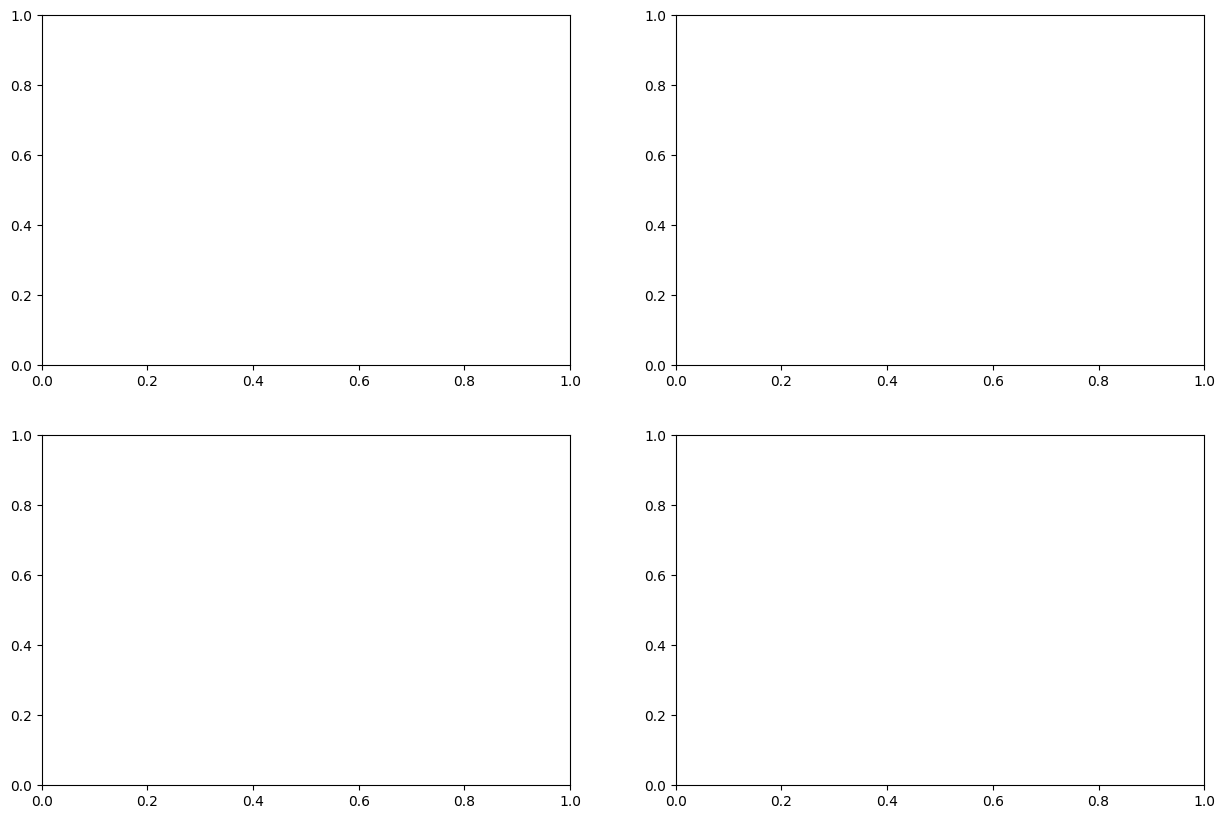

In [6]:
import matplotlib.pyplot as plt

# Loss 곡선
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Total Loss
axes[0, 0].plot(train_history['total_loss'], label='Train', marker='o')
axes[0, 0].plot(val_history['total_loss'], label='Validation', marker='s')
axes[0, 0].set_title('Total Loss')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Policy Loss
axes[0, 1].plot(train_history['policy_loss'], label='Train', marker='o')
axes[0, 1].plot(val_history['policy_loss'], label='Validation', marker='s')
axes[0, 1].set_title('Policy Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Value Loss
axes[1, 0].plot(train_history['value_loss'], label='Train', marker='o')
axes[1, 0].plot(val_history['value_loss'], label='Validation', marker='s')
axes[1, 0].set_title('Value Loss')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Accuracy
axes[1, 1].plot(val_history['accuracy'], label='Validation', marker='s', color='green')
axes[1, 1].set_title('Policy Accuracy')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(MODEL_DIR / 'training_curves.png', dpi=150)
plt.show()

print("학습 곡선 저장 완료:", MODEL_DIR / 'training_curves.png')

## 모델 평가

### 검증 전용 설정 (학습 없이 실행 시)

학습 없이 저장된 모델만 평가할 때 사용합니다.
- **Cell 1 (임포트) → Cell 3 (모델 생성) → 이 셀 → 모델 평가 셀** 순서로 실행
- train_loader를 생성하지 않아 메모리 절약
- num_workers=0으로 OOM 방지
- validate 함수는 Cell 1에서 train_utils.py로부터 자동 import됨

In [ ]:
# =============================================================================
# 검증 전용 설정 (학습 없이 모델 평가만 할 때 사용)
# =============================================================================
# 데이터 디렉토리 설정
PARQUET_DIR = "data/parquet"
TRAIN_RATIO = 0.9
BATCH_SIZE = 4096
CHUNK_SIZE = 32768

# 파일 정보 수집 및 분할 (val_files만 사용)
parquet_files, file_lengths = get_parquet_file_info(PARQUET_DIR, "chess_samples_*.parquet")
_, val_files, _, val_lengths, _, val_samples = split_files_by_ratio(
    parquet_files, 
    file_lengths, 
    train_ratio=TRAIN_RATIO,
    shuffle=False
)

# 검증 데이터셋만 생성
print("\n검증 데이터셋 생성 중...")
val_dataset = ParquetChessDataset(
    parquet_files=val_files,
    file_lengths=val_lengths,
    shuffle_files=False,
    seed=42,
    batch_size=BATCH_SIZE,
    chunk_size=CHUNK_SIZE
)

print(f"검증 데이터: {val_dataset.estimated_length:,} 샘플")

VAL_STEPS_PER_EPOCH = val_dataset.estimated_length // BATCH_SIZE
print(f"검증 이터레이션: {VAL_STEPS_PER_EPOCH:,} steps")

# 검증용 DataLoader (워커 없이 - 메모리 절약)
val_loader = DataLoader(
    val_dataset,
    batch_size=None,
    shuffle=False,
    num_workers=0,  # 워커 없이 실행 (OOM 방지)
    pin_memory=False,
)

# Loss 함수 정의
policy_loss_fn = nn.CrossEntropyLoss()
value_loss_fn = nn.MSELoss()

# 모델 경로 설정
MODEL_DIR = Path("models")
BEST_MODEL_PATH = MODEL_DIR / "best_chess_cnn.pth"
LAST_MODEL_PATH = MODEL_DIR / "last_chess_cnn.pth"

POLICY_WEIGHT = 1.0
VALUE_WEIGHT = 1.0
USE_AMP = torch.cuda.is_available()

print("\n검증 준비 완료!")

NameError: name 'get_parquet_file_info' is not defined

In [7]:
checkpoint = torch.load(BEST_MODEL_PATH, map_location=device, weights_only=False)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"로드된 모델 정보:")
print(f"  Epoch: {checkpoint['epoch']}")
print(f"  Validation Loss: {checkpoint['val_loss']:.4f}")
print(f"  Validation Accuracy: {checkpoint['val_accuracy']:.4f} ({checkpoint['val_accuracy']*100:.2f}%)")
if 'learning_rate' in checkpoint:
    print(f"  Learning Rate: {checkpoint['learning_rate']:.6f}")
if 'train_loss' in checkpoint:
    print(f"  Train Loss: {checkpoint['train_loss']:.4f}")

# 최종 검증
final_metrics = validate(
    model, val_loader, policy_loss_fn, value_loss_fn,
    POLICY_WEIGHT, VALUE_WEIGHT, device,
    use_amp=USE_AMP, total_steps=VAL_STEPS_PER_EPOCH
)

print(f"\n최종 검증 결과:")
print(f"  Policy Loss: {final_metrics['policy_loss']:.4f}")
print(f"  Value Loss: {final_metrics['value_loss']:.4f}")
print(f"  Total Loss: {final_metrics['total_loss']:.4f}")
print(f"  --- 정확도 ---")
print(f"  Top-1 Acc: {final_metrics['accuracy']*100:.2f}% | Top-3: {final_metrics['top3_acc']*100:.2f}% | Top-5: {final_metrics['top5_acc']*100:.2f}% | Top-10: {final_metrics['top10_acc']*100:.2f}%")
print(f"  Masked Top-1 Acc: {final_metrics['masked_acc']*100:.2f}%")
print(f"  --- Rank 분석 ---")
print(f"  MRR: {final_metrics['mrr']:.4f} | Avg Rank: {final_metrics['avg_rank']:.2f}")
print(f"  --- 분포 분석 ---")
print(f"  Entropy (legal): {final_metrics['entropy']:.4f} | Legal Prob Mass: {final_metrics['legal_prob_mass']*100:.2f}%")

로드된 모델 정보:
  Epoch: 5
  Validation Loss: 2.6870
  Validation Accuracy: 0.4469 (44.69%)
  Learning Rate: 0.008000
  Train Loss: 2.6012


검증 중:   0%|          | 0/537 [00:06<?, ?it/s]


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/IPython/core/interactiveshell.py", line 3701, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_10001/969328209.py", line 15, in <module>
    final_metrics = validate(
                    ^^^^^^^^^
  File "/tmp/ipykernel_10001/2532236701.py", line 107, in validate
    for states, policies, masks, values in tqdm(dataloader, desc="검증 중", total=total_steps):
  File "/usr/local/lib/python3.12/dist-packages/tqdm/std.py", line 1181, in __iter__
    for obj in iterable:
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 740, in __next__
    data = self._next_data()
           ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1505, in _next_data
    idx, data = self._get_data()
                ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.p

## 샘플 예측 확인

In [9]:
# 몇 개 샘플로 예측 확인
model.eval()
non_blocking = torch.cuda.is_available()

with torch.no_grad():
    for states, policies, masks, values in val_loader:
        states = states.to(device, non_blocking=non_blocking)
        masks = masks.to(device, non_blocking=non_blocking)
        
        policy_logits, value_pred = model(states, masks)
        policy_probs = torch.softmax(policy_logits, dim=1)
        pred_policies = policy_logits.argmax(dim=1)
        
        print("샘플 예측:")
        for i in range(min(5, len(states))):
            print(f"\n샘플 {i+1}:")
            print(f"  실제 Policy: {policies[i].item()}")
            print(f"  예측 Policy: {pred_policies[i].item()}")
            print(f"  정확도: {'✅' if pred_policies[i] == policies[i] else '❌'}")
            print(f"  실제 Value: {values[i].item():.4f}")
            print(f"  예측 Value: {value_pred[i].item():.4f}")
            print(f"  예측 확률 (top-1): {policy_probs[i].max().item():.4f}")
        
        break

RuntimeError: DataLoader worker (pid(s) 3587) exited unexpectedly

## 모델 저장 (강화학습용)

In [ ]:
# 강화학습용 모델 저장 (state_dict만)
RL_MODEL_PATH = MODEL_DIR / "chess_cnn_rl.pth"
torch.save(model.state_dict(), RL_MODEL_PATH)

print(f"강화학습용 모델 저장 완료: {RL_MODEL_PATH}")
print(f"\n강화학습에서 사용 방법:")
print(f"  model = ChessCNN(num_channels=256)")
print(f"  model.load_state_dict(torch.load('{RL_MODEL_PATH}'))")
print(f"  model.eval()")